# USAD

## Environment

In [4]:
!rm -r sample_data

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
!git clone https://github.com/manigalati/usad

In [3]:
%cd usad

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

from utils import *
from usad import *

In [8]:
!nvidia-smi -L

device = get_default_device()

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


## EDA - Data Pre-Processing

### Download dataset

In [11]:
!mkdir input
#normal period
!python gdrivedl.py https://drive.google.com/open?id=1rVJ5ry5GG-ZZi5yI4x9lICB8VhErXwCw input/
#anomalies
!python gdrivedl.py https://drive.google.com/open?id=1iDYc0OEmidN712fquOBRFjln90SbpaE7 input/

A subdirectory or file input already exists.


input/SWaT_Dataset_Normal_v1.csv [Exists]


c:\Users\lisae\usad\gdrivedl.py:25: SyntaxWarning: invalid escape sequence '\['
  FILE_PATTERN = re.compile("itemJson: (\[.*?)};</script>",
c:\Users\lisae\usad\gdrivedl.py:27: SyntaxWarning: invalid escape sequence '\['
  FOLDER_PATTERN = re.compile("window\['_DRIVE_ivd'\] = '(.*?)';",
c:\Users\lisae\usad\gdrivedl.py:90: SyntaxWarning: invalid escape sequence '\/'
  data = match.group(1).replace('\/', '/')
c:\Users\lisae\usad\gdrivedl.py:115: SyntaxWarning: invalid escape sequence '\/'
  data = match.group(1).replace('\/', '/')


input/SWaT_Dataset_Attack_v0.csv [Exists]


c:\Users\lisae\usad\gdrivedl.py:25: SyntaxWarning: invalid escape sequence '\['
  FILE_PATTERN = re.compile("itemJson: (\[.*?)};</script>",
c:\Users\lisae\usad\gdrivedl.py:27: SyntaxWarning: invalid escape sequence '\['
  FOLDER_PATTERN = re.compile("window\['_DRIVE_ivd'\] = '(.*?)';",
c:\Users\lisae\usad\gdrivedl.py:90: SyntaxWarning: invalid escape sequence '\/'
  data = match.group(1).replace('\/', '/')
c:\Users\lisae\usad\gdrivedl.py:115: SyntaxWarning: invalid escape sequence '\/'
  data = match.group(1).replace('\/', '/')


### Normal period

In [60]:
#Read data
normal = pd.read_csv("input/capturingMQTTOTData.csv", header=None,nrows=1000)
#normal = normal.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
#Drop last column
normal = normal.drop(columns=9)
#Change the date and time
normal[0] = pd.to_datetime(normal[0])
normal[0] = normal[0].diff()

normal.shape
normal.head()

,0,1,2,3,4,5,6,7,8
0,NaT,79,N143,T1,400,Ia,MF7,30.3,True
1,0 days 00:00:00.952637,83,N143,LV1,GRP5,Ib,MF43,-28.3,True
2,0 days 00:00:03.209656,78,N143,T1,400,Q,MF3,25.3,True
3,0 days 00:00:00.050219,78,N143,T1,400,S,MF4,28.2,True
4,0 days 00:00:00.050372,78,N143,T1,400,Q,MF3,26.4,True


In [61]:
for i in list(normal): 
    normal[i] = normal[i].apply(lambda x: str(x).replace("," , "."))
    #Change False/True -> 0/1 and stations
for key in normal:
    normal[key] = [1 if value == 'True' else (0 if value == 'False' else value) for value in normal[key]]
    normal[key] = [1 if value == 'N143' else (3 if value == 'N171' else value) for value in normal[key]]



normal.head()

,0,1,2,3,4,5,6,7,8
0,NaT,79,1,T1,400,Ia,MF7,30.3,1
1,0 days 00:00:00.952637,83,1,LV1,GRP5,Ib,MF43,-28.3,1
2,0 days 00:00:03.209656,78,1,T1,400,Q,MF3,25.3,1
3,0 days 00:00:00.050219,78,1,T1,400,S,MF4,28.2,1
4,0 days 00:00:00.050372,78,1,T1,400,Q,MF3,26.4,1


In [62]:
# Transform all columns into float64
for i in list(normal): 
    normal[i]=normal[i].apply(lambda x: str(x).replace("," , "."))
normal = normal.astype(float)

ValueError: could not convert string to float: 'MF7'

#### Normalization

In [5]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

In [6]:
normal.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.0,0.027113,0.5,0.0,0.0,0.025084,0.017123,0.0,0.0,0.5,...,0.0,0.0,0.0,0.135417,0.0,0.154639,1.0,0.0,0.0,0.0
1,0.0,0.027690,0.5,0.0,0.0,0.025084,0.017123,0.0,0.0,0.5,...,0.0,0.0,0.0,0.135417,0.0,0.154639,1.0,0.0,0.0,0.0


### Attack

In [9]:
#Read data
attack = pd.read_csv("input/SWaT_Dataset_Attack_v0.csv",sep=";", nrows=1000)
labels = [ float(label!= 'Normal' ) for label  in attack["Normal/Attack"].values]
attack = attack.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
attack.shape

(1000, 51)

In [10]:
# Transform all columns into float64
for i in list(attack):
    attack[i]=attack[i].apply(lambda x: str(x).replace("," , "."))
attack = attack.astype(float)

#### Normalization

In [11]:
from sklearn import preprocessing

x = attack.values 
x_scaled = min_max_scaler.transform(x)
attack = pd.DataFrame(x_scaled)

In [12]:
attack.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.908306,2.955581,1.0,1.0,0.0,1.012532,0.164954,0.182786,0.985437,1.0,...,800.833394,1.0,0.0,157.322753,1.649953,119.999963,0.333251,0.0,0.0,0.0
1,0.915498,2.955870,1.0,1.0,0.0,1.012532,0.164954,0.182786,0.985437,1.0,...,800.833394,1.0,0.0,157.322753,1.649953,120.051505,0.333251,0.0,0.0,0.0


### Windows

In [13]:
window_size=12

In [14]:
windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]]
windows_normal.shape

(988, 12, 51)

In [15]:
windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]
windows_attack.shape

(988, 12, 51)

## Training

In [17]:
import torch.utils.data as data_utils

BATCH_SIZE =  7919
N_EPOCHS = 100
hidden_size = 100

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:int(np.floor(.8 *  windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 *  windows_normal.shape[0])):int(np.floor(windows_normal.shape[0]))]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [18]:
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch [0], val_loss1: 0.2048, val_loss2: 0.2040
Epoch [1], val_loss1: 0.2030, val_loss2: -0.0001
Epoch [2], val_loss1: 0.2013, val_loss2: -0.0672
Epoch [3], val_loss1: 0.1996, val_loss2: -0.1002
Epoch [4], val_loss1: 0.1980, val_loss2: -0.1198
Epoch [5], val_loss1: 0.1962, val_loss2: -0.1327
Epoch [6], val_loss1: 0.1939, val_loss2: -0.1417
Epoch [7], val_loss1: 0.1917, val_loss2: -0.1482
Epoch [8], val_loss1: 0.1915, val_loss2: -0.1536
Epoch [9], val_loss1: 0.1929, val_loss2: -0.1585
Epoch [10], val_loss1: 0.1953, val_loss2: -0.1633
Epoch [11], val_loss1: 0.1972, val_loss2: -0.1672
Epoch [12], val_loss1: 0.1971, val_loss2: -0.1692
Epoch [13], val_loss1: 0.1954, val_loss2: -0.1694
Epoch [14], val_loss1: 0.1925, val_loss2: -0.1684
Epoch [15], val_loss1: 0.1889, val_loss2: -0.1665
Epoch [16], val_loss1: 0.1851, val_loss2: -0.1643
Epoch [17], val_loss1: 0.1826, val_loss2: -0.1632
Epoch [18], val_loss1: 0.1818, val_loss2: -0.1636
Epoch [19], val_loss1: 0.1827, val_loss2: -0.1654
Epoch [20],

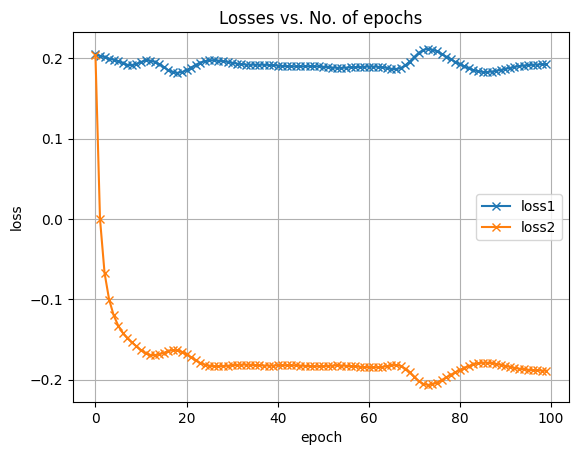

In [19]:
plot_history(history)

In [20]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model.pth")

## Testing

In [21]:
checkpoint = torch.load("model.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [22]:
results=testing(model,test_loader)

In [23]:
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int_(labels[i:i+window_size])))

In [24]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ]

In [26]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

RuntimeError: stack expects a non-empty TensorList

In [27]:
threshold=ROC(y_test,y_pred)

NameError: name 'y_pred' is not defined